In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import utils
import datasets
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, Activation , Flatten, Dense
from keras.layers import LSTM, GRU
from keras.layers import Deconv3D,UpSampling3D, Activation


Using TensorFlow backend.


In [3]:
# some magic commands
%matplotlib inline
%load_ext autoreload

[load_dataset] loading ShapeNet
[construct_paths] for dir ShapeNet
[fetch_renders_from_disk]


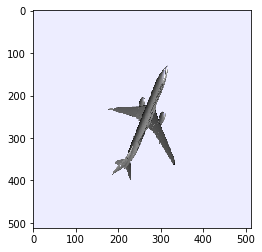

In [4]:
# load data and display random example
X=datasets.load_dataset("ShapeNet")
input_shape=X.shape[1:]
plt.imshow(random.choice(X))

In [5]:
# net parameters
conv_filter_count = [96, 128, 256, 256, 256, 256]
deconv_filter_count = [128, 128, 128, 64, 32, 2]

In [6]:
# encoder network
print(X.shape)
cur_tensor=Input(shape=input_shape);
Conv2D(filters=conv_filter_count[0],kernel_size= (7,7),input_shape=input_shape)(cur_tensor)
for i in range(1,6):
    cur_tensor=Conv2D(filters=conv_filter_count[i],kernel_size= (3,3))(cur_tensor)
    cur_tensor=MaxPooling2D()(cur_tensor)
    cur_tensor=Activation('relu')(cur_tensor)
    print(cur_tensor.shape)

(5, 512, 512, 3)
(?, 255, 255, 128)
(?, 126, 126, 256)
(?, 62, 62, 256)
(?, 30, 30, 256)
(?, 14, 14, 256)


In [ ]:
gru_grid= utils.grid3D(GRU(1024))

In [ ]:
%autoreload
grid_slice=utils.get_neighbors(gru_grid,[4,4,4])

In [ ]:
# lstm
Flatten()
print(net.output.get_shape())

In [ ]:
Dense(1024)
print(net.output.shape)
gru_layer=GRU(1024)

In [ ]:
# decoder network
for i in range(6):
    Deconv3D(filters=deconv_filter_count[i],kernel_size=(3,3,3))
    UpSampling3D()
    Activation('relu')
    print(net.output.shape)
    
print(net.output.shape())

In [ ]:
net = Model(input=X,output=)

In [ ]:
net.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
os.system("rm -rf ./logs/*")
tensor_board=TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
net.fit(X,np.random.rand(len(X),n_fc_filters[0]),epochs=1,callbacks=[tensor_board])